In [291]:
import logging
import os
import random
from collections import Counter

import numpy as np
import scanpy as sc

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory
import pollock.models.analysis as pollock_analysis

In [229]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

In [223]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load in dataset


In [224]:
adata = sc.read_loom('/Users/erikstorrs/Documents/ding/imaging/data/htan/single_cell/TWCE-HT061P1-S1PAA1A1Z1B1_processed_annotated.loom')
adata

/Users/erikstorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/loompy/loom_layer.py:123: RuntimeWarning: invalid value encountered in not_equal
  nonzeros = np.where(vals != 0)


AnnData object with n_obs × n_vars = 2131 × 19532 
    obs: 'ClusterID', 'ClusterName', 'SCT_snn_res_0_5', 'cell_type', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'percent_mito', 'seurat_clusters'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [225]:
## get rid of unknown
adata = adata[adata.obs['ClusterName']!='Unknown', :]
adata

View of AnnData object with n_obs × n_vars = 1991 × 19532 
    obs: 'ClusterID', 'ClusterName', 'SCT_snn_res_0_5', 'cell_type', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'percent_mito', 'seurat_clusters'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [226]:
# ## subsample for testing purposes
# idxs = random.sample(list(range(adata.shape[0])), k=1000)
# adata = adata[idxs, :]
# adata

In [227]:
c = Counter(adata.obs['ClusterName'])
c.most_common()

[('Ductal', 430),
 ('CD4_T', 361),
 ('Fibroblast', 285),
 ('CD8_T', 245),
 ('Macrophage', 146),
 ('Endothelial', 145),
 ('Mast', 117),
 ('Acinar', 108),
 ('NK', 67),
 ('Treg', 45),
 ('B', 21),
 ('Plasma', 21)]

In [175]:
# import pollock.preprocessing.preprocessing as pp
# list(pp.listfiles(os.getcwd(), regex=r'\.tfcache'))

['/Users/erikstorrs/Documents/ding/pollock/notebooks/validation.tfcache.index',
 '/Users/erikstorrs/Documents/ding/pollock/notebooks/training.tfcache.index',
 '/Users/erikstorrs/Documents/ding/pollock/notebooks/training.tfcache.data-00000-of-00001',
 '/Users/erikstorrs/Documents/ding/pollock/notebooks/validation.tfcache.data-00000-of-00001']

In [240]:
np.concatenate

"<class 'scipy.sparse.csr.csr_matrix'>"

## train with pollock

In [265]:
%%time

pollock_dataset = PollockDataset(adata, dataset_type='training',
                                image_root_dir=os.path.join(os.getcwd(), 'scratch', 'test_training'),
                                n_per_cell_type=500, max_val_per_cell_type=500)

CPU times: user 1min 14s, sys: 2.74 s, total: 1min 17s
Wall time: 1min 17s


array([[2., 2., 2., ..., 3., 3., 3.],
       [2., 2., 2., ..., 3., 3., 3.],
       [2., 2., 2., ..., 3., 3., 3.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

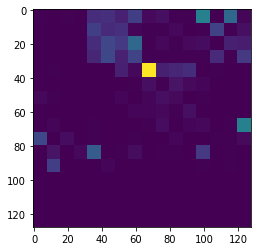

In [266]:
cell_id = adata.obs.index[10]
pollock_dataset.get_cell_image(cell_id)

In [267]:
pollock_dataset.cell_types

['Acinar',
 'B',
 'CD4_T',
 'CD8_T',
 'Ductal',
 'Endothelial',
 'Fibroblast',
 'Macrophage',
 'Mast',
 'NK',
 'Plasma',
 'Treg']

In [268]:
x, y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 12]))

In [269]:
model = PollockModel(pollock_dataset.cell_types)

In [270]:
model.fit(pollock_dataset)

Train for 94 steps, validate for 7 steps
Epoch 1/10
94/94 [==============================] - 32s 336ms/step - loss: 0.3035 - accuracy: 0.8954 - val_loss: 0.2706 - val_accuracy: 0.8906
Epoch 2/10
94/94 [==============================] - 29s 309ms/step - loss: 0.0909 - accuracy: 0.9679 - val_loss: 0.1469 - val_accuracy: 0.9487
Epoch 3/10
94/94 [==============================] - 28s 301ms/step - loss: 0.0499 - accuracy: 0.9820 - val_loss: 0.1933 - val_accuracy: 0.9397
Epoch 4/10
94/94 [==============================] - 28s 294ms/step - loss: 0.0418 - accuracy: 0.9852 - val_loss: 0.1727 - val_accuracy: 0.9241


In [275]:
model.save(pollock_dataset, 'scratch/test_model')

In [278]:
%%time
prediction_dataset, model = load_from_directory(adata, 'scratch/test_model',
        image_root_dir = os.path.join(os.getcwd(), 'scratch', 'prediction'))

Found 1991 images belonging to 1 classes.


In [184]:
# prediction_dataset = PollockDataset(adata, dataset_type='prediction',
#                                    image_root_dir=os.path.join(os.getcwd(), 'test_prediction'),
#                                    gene_template=pollock_dataset.gene_template,
#                                    cell_type_template=pollock_dataset.cell_type_template,
#                                    cell_types=pollock_dataset.cell_types,
#                                    batch_size=64)

Found 1991 images belonging to 1 classes.


In [279]:
probs = model.predict(prediction_dataset)
probs.shape

(1991, 12)

In [280]:
predictions = np.argmax(probs, axis=1).flatten()
predicted_labels = [prediction_dataset.cell_types[i] for i in predictions]
len(predictions), predictions[:5]

(1991, array([2, 4, 6, 4, 2]))

In [281]:
len(set(prediction_dataset.cell_ids))

1991

In [282]:
cell_type_to_index = {v:k for k, v in enumerate(prediction_dataset.cell_types)}
groundtruth = [cell_type_to_index[cell_type]
               for cell_type in adata[prediction_dataset.cell_ids, :].obs['cell_type']]
len(groundtruth), groundtruth[:5]

(1991, [2, 4, 6, 4, 2])

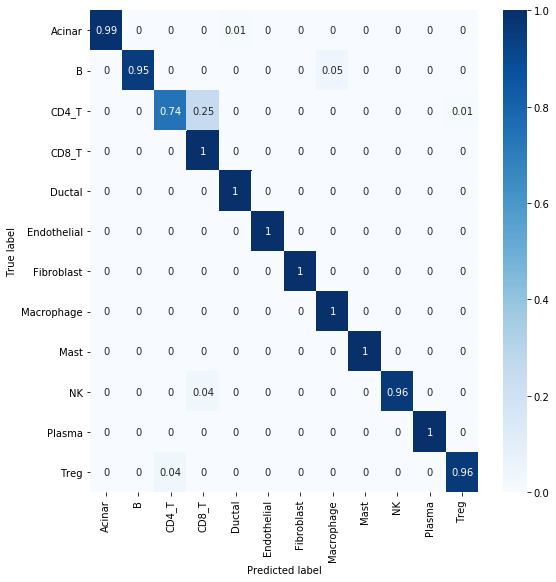

In [283]:
c_df = pollock_analysis.get_confusion_matrix(predictions, groundtruth, prediction_dataset.cell_types)

In [284]:
embedding = pollock_analysis.umap_final_layer(prediction_dataset.prediction_ds, model.model)
embedding.shape

(1991, 2)

... storing 'predicted_cell_type' as categorical


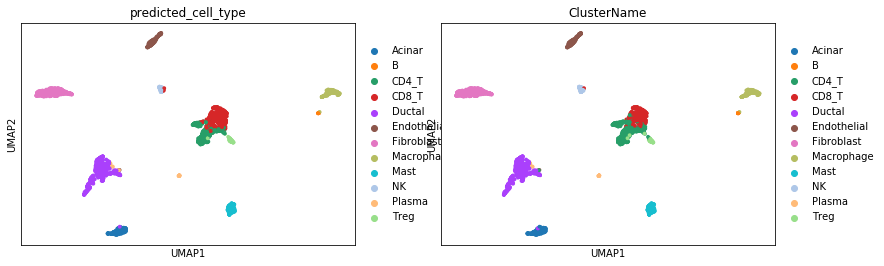

In [285]:
adata.obsm['X_umap'] = embedding
adata.obs['predicted_cell_type'] = predicted_labels
sc.pl.umap(adata, color=['predicted_cell_type', 'ClusterName'])

In [286]:
pollock_dataset.cell_types

['Acinar',
 'B',
 'CD4_T',
 'CD8_T',
 'Ductal',
 'Endothelial',
 'Fibroblast',
 'Macrophage',
 'Mast',
 'NK',
 'Plasma',
 'Treg']

In [287]:
x, y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 12]))

In [288]:
y_labels = np.asarray([prediction_dataset.cell_types[i] for i in np.argmax(y, axis=1).flatten()])
acinar_inputs = x[y_labels == 'Acinar']
acinar_inputs.shape

TensorShape([8, 128, 128, 3])

array([[19, 22, 11, ...,  4,  9,  2],
       [10, 23, 35, ...,  6,  8,  1],
       [18, 73, 92, ...,  8,  3,  1],
       ...,
       [ 2,  7, 14, ...,  0,  0,  0],
       [ 1, 12, 26, ...,  0,  0,  0],
       [ 1, 10, 10, ...,  0,  0,  0]], dtype=uint8)

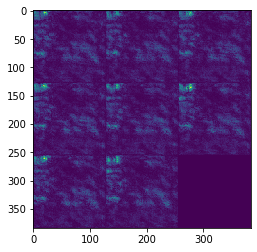

In [289]:
pollock_analysis.explain_predictions(model.model, acinar_inputs, 0)

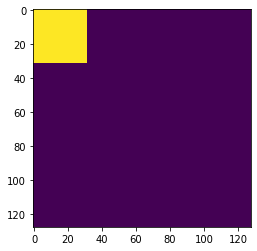

In [290]:
import matplotlib.pyplot as plt
plt.imshow(pollock_dataset.cell_type_template=='Acinar')